In [15]:
import os
from pathlib import Path
from decimal import ROUND_HALF_UP, Decimal

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [16]:
# I/O Func
MODEL_NAME = "APPLE"
BASE_PATH = Path(f'/kaggle/working')

def adjusting_price(price, key: str):
    """[Adjusting Close Price]
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """

    def generate_adjusted(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, f"CumulativeAdjustmentFactor{key}"] = df["AdjustmentFactor"].cumprod()
        # generate AdjustedClose
        df.loc[:, f"Adjusted{key}"] = (
            df[f"CumulativeAdjustmentFactor{key}"] * df[key]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        # reverse order
        df = df.sort_values("Date")
        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df[f"Adjusted{key}"] == 0, f"Adjusted{key}"] = np.nan
        # forward fill AdjustedClose
        df.loc[:, f"Adjusted{key}"] = df.loc[:, f"Adjusted{key}"].ffill()
        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted).reset_index(drop=True)

    # price.set_index("Date", inplace=True)
    return price

def adjusting_volume(price, key = "Volume"):
    """[Adjusting Close Price]
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """

    def generate_adjusted(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, f"CumulativeAdjustmentFactor{key}"] = df["AdjustmentFactor"].cumprod()
        # generate AdjustedClose
        df.loc[:, f"Adjusted{key}"] = (
            df[key] / df[f"CumulativeAdjustmentFactor{key}"]  
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        # reverse order
        df = df.sort_values("Date")
        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df[f"Adjusted{key}"] == 0, f"Adjusted{key}"] = np.nan
        # forward fill AdjustedClose
        df.loc[:, f"Adjusted{key}"] = df.loc[:, f"Adjusted{key}"].ffill()
        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted).reset_index(drop=True)

    # price.set_index("Date", inplace=True)
    return price

def read_prices(dir_name: str, securities_code: int = None):
    """[Important: the dateset of 2020/10/1 is lost because of system failer in JPX, see: https://www.jpx.co.jp/corporate/news/news-releases/0060/20201019-01.html]
    
    """
    base_path = Path(f'../input/jpx-tokyo-stock-exchange-prediction/{dir_name}')
    df = pd.read_csv(base_path / 'stock_prices.csv')
    df.loc[: ,"Date"] = pd.to_datetime(df.loc[: ,"Date"], format="%Y-%m-%d")
    df = df[df['Open'].notna()]
    if securities_code:
        df = df[df["SecuritiesCode"] == securities_code]
    return df

def read_stock_list(securities_code: int = None, only_universe: bool = True):
    df = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/stock_list.csv')
    df.loc[: ,"EffectiveDate"] = pd.to_datetime(df.loc[: ,"EffectiveDate"], format="%Y%m%d")
    if only_universe:
        df = df[df['Universe0']]
    if securities_code:
        df = df[df["SecuritiesCode"] == securities_code]
    return df

def merge_data(prices, stock_list):
    # stock_prices がベース
    base_df = prices.copy()
    
    # stock_listと結合
    _stock_list = stock_list.copy()
    _stock_list.rename(columns={'Close': 'Close_x'}, inplace=True)
    base_df = base_df.merge(_stock_list, on='SecuritiesCode', how="left")
    
    return base_df

def read_train_data_by_price(securities_code: int = None, with_supplemental: bool = True):
    """[The train base is price dataset, the other data are joined to prices DF by left join]
    
    """
    # origin
    df = merge_data(prices=read_prices(dir_name="train_files", securities_code=securities_code), stock_list=read_stock_list(securities_code=securities_code))
    
    # supplyment
    if with_supplemental:
        supplemental_df = merge_data(prices=read_prices(dir_name="supplemental_files", securities_code=securities_code), stock_list=read_stock_list(securities_code=securities_code))
        df = pd.concat([df, supplemental_df]).reset_index(drop=True)
        
    df = adjusting_price(df, "Close")
    df = adjusting_price(df, "Open")
    df = adjusting_price(df, "High")
    df = adjusting_price(df, "Low")
    df = adjusting_volume(df)
    return df

def collector(prices, options, financials, trades, secondary_prices, stock_list):
    # 読み込んだデータを統合して一つのファイルに纏める
    df = merge_data(prices, stock_list)
    # AdjustedClose項目の生成
    df = adjusting_price(df, "Close")
    df = adjusting_price(df, "Open")
    df = adjusting_price(df, "High")
    df = adjusting_price(df, "Low")
    df = adjusting_volume(df)
    return df

def write_df(df, filename):
    df.to_csv(f'{BASE_PATH}/{filename}_{MODEL_NAME}.csv',index = False)
    
import joblib
def write_model(model, name):
    # save model
    joblib.dump(model, f'{BASE_PATH}/{name}_{MODEL_NAME}.pkl')


# load model
def read_model(name):
    return joblib.load(f'{BASE_PATH}/{name}_{MODEL_NAME}.pkl')

In [17]:
train_df = read_train_data_by_price()
train_df

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,...,CumulativeAdjustmentFactorClose,AdjustedClose,CumulativeAdjustmentFactorOpen,AdjustedOpen,CumulativeAdjustmentFactorHigh,AdjustedHigh,CumulativeAdjustmentFactorLow,AdjustedLow,CumulativeAdjustmentFactorVolume,AdjustedVolume
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,...,1.0,2742.0,1.0,2734.0,1.0,2755.0,1.0,2730.0,1.0,31400.0
1,20170105_1301,2017-01-05,1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,NaN,...,1.0,2738.0,1.0,2743.0,1.0,2747.0,1.0,2735.0,1.0,17900.0
2,20170106_1301,2017-01-06,1301,2734.0,2744.0,2720.0,2740.0,19900,1.0,NaN,...,1.0,2740.0,1.0,2734.0,1.0,2744.0,1.0,2720.0,1.0,19900.0
3,20170110_1301,2017-01-10,1301,2745.0,2754.0,2735.0,2748.0,24200,1.0,NaN,...,1.0,2748.0,1.0,2745.0,1.0,2754.0,1.0,2735.0,1.0,24200.0
4,20170111_1301,2017-01-11,1301,2748.0,2752.0,2737.0,2745.0,9300,1.0,NaN,...,1.0,2745.0,1.0,2748.0,1.0,2752.0,1.0,2737.0,1.0,9300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2436634,20220221_9997,2022-02-21,9997,725.0,729.0,719.0,727.0,116400,1.0,NaN,...,1.0,727.0,1.0,725.0,1.0,729.0,1.0,719.0,1.0,116400.0
2436635,20220222_9997,2022-02-22,9997,719.0,723.0,711.0,721.0,225500,1.0,NaN,...,1.0,721.0,1.0,719.0,1.0,723.0,1.0,711.0,1.0,225500.0
2436636,20220224_9997,2022-02-24,9997,709.0,725.0,708.0,719.0,195600,1.0,NaN,...,1.0,719.0,1.0,709.0,1.0,725.0,1.0,708.0,1.0,195600.0
2436637,20220225_9997,2022-02-25,9997,725.0,738.0,724.0,733.0,170500,1.0,NaN,...,1.0,733.0,1.0,725.0,1.0,738.0,1.0,724.0,1.0,170500.0


# Featrue

In [18]:
def cal_moving_average(key:str, periods):
    def func(df):
        for period in periods:
            col = f"MovingAverage{key}{period}"
            col_gap = f"{col}GapPercent"
            df[col] = df[key].rolling(period, min_periods=1).mean()
            df[col_gap] = (df[key] / df[col]) * 100.0
        return df
    return func

def cal_changing_ration(key:str, periods):
    def func(df):
        for period in periods:
            col = f"ChangingRatio{key}{period}"
            df[col] = df[key].pct_change(period) * 100
        return df
    return func

def cal_historical_vix(key: str, periods):
    def func(df):
        for period in periods:
            col = f"HistoricalVIX{key}{period}"
            df[col] = np.log(df[key]).diff().rolling(period).std()
        return df
    return func

def add_columns_per_code(df, functions):
    def func(df):
        for f in functions:
            df = f(df)
        return df
    df = df.sort_values(["SecuritiesCode", "Date"])
    df = df.groupby("SecuritiesCode").apply(func)
    df = df.reset_index(drop=True)
    return df

def add_columns_per_day(base_df):
    base_df['diff_rate1'] = (base_df['Close'] - base_df['Open']) / base_df['Close']
    base_df['diff_rate2'] = (base_df['High'] - base_df['Low']) / base_df['Close']    
    return base_df

def generate_features(df):
    base_df = df.copy()
    prev_column_names = base_df.columns
    periods = [5, 25, 75]
    functions = [
        cal_moving_average("AdjustedClose", periods),
        cal_moving_average("AdjustedOpen", periods),
        cal_moving_average("AdjustedHigh", periods),
        cal_moving_average("AdjustedLow", periods),
        cal_moving_average("AdjustedVolume", periods),
        cal_changing_ration("AdjustedClose", periods),
        cal_changing_ration("AdjustedOpen", periods),
        cal_changing_ration("AdjustedHigh", periods),
        cal_changing_ration("AdjustedLow", periods),
        cal_changing_ration("AdjustedVolume", periods),
        cal_historical_vix("AdjustedClose", periods),
        cal_historical_vix("AdjustedOpen", periods),
        cal_historical_vix("AdjustedHigh", periods),
        cal_historical_vix("AdjustedLow", periods),
        cal_historical_vix("AdjustedVolume", periods)
    ]
    
    base_df = add_columns_per_code(base_df, functions)
    base_df = add_columns_per_day(base_df)
    
    add_column_names = list(set(base_df.columns) - set(prev_column_names))
    #feats = feats[feats["HistoricalVIXAdjustedClose75"] != 0]
    return base_df, add_column_names

def select_features(feature_df, add_column_names, is_train):
    base_cols = ['RowId', 'Date', 'SecuritiesCode']
    numerical_cols = sorted(add_column_names)
    categorical_cols = ['NewMarketSegment', '33SectorCode', '17SectorCode']
    label_col = ['Target']
    feat_cols = numerical_cols + categorical_cols
    feature_df = feature_df[base_cols + feat_cols + label_col]
    feature_df[categorical_cols] = feature_df[categorical_cols].astype('category')
    if is_train:
        feature_df.dropna(inplace=True)
    else:
        feature_df[numerical_cols] = feature_df[numerical_cols].fillna(0)
        feature_df[numerical_cols] = feature_df[numerical_cols].replace([np.inf, -np.inf], 0)
    return feature_df, feat_cols, label_col

def preprocessor(base_df, is_train=True):
    feature_df = base_df.copy()
    
    ## 特徴量生成
    feature_df, add_column_names = generate_features(feature_df)
    
    ## 特徴量選択
    feature_df, feat_cols, label_col = select_features(feature_df, add_column_names, is_train)

    return feature_df, feat_cols, label_col

feature_df, feat_cols, label_col = preprocessor(train_df)

# modelの結果をもとにfeat_colsを上書き
feat_cols = ['33SectorCode', 'ChangingRatioAdjustedVolume25', 'diff_rate2', 'MovingAverageAdjustedHigh5GapPercent', 'MovingAverageAdjustedOpen5GapPercent', 'HistoricalVIXAdjustedLow5', 'MovingAverageAdjustedClose5GapPercent', 'HistoricalVIXAdjustedOpen5', 'MovingAverageAdjustedLow25GapPercent', 'ChangingRatioAdjustedVolume5', 'HistoricalVIXAdjustedOpen75', 'HistoricalVIXAdjustedVolume5', 'MovingAverageAdjustedVolume25GapPercent', 'diff_rate1', 'ChangingRatioAdjustedHigh5', 'ChangingRatioAdjustedOpen25', 'HistoricalVIXAdjustedOpen25', 'MovingAverageAdjustedClose25GapPercent', 'MovingAverageAdjustedVolume75GapPercent', 'ChangingRatioAdjustedLow25', 'ChangingRatioAdjustedLow5', 'HistoricalVIXAdjustedHigh75', 'MovingAverageAdjustedLow5GapPercent', 'ChangingRatioAdjustedClose75', 'MovingAverageAdjustedClose75', 'MovingAverageAdjustedClose75GapPercent', 'HistoricalVIXAdjustedVolume75']
feat_cols

['33SectorCode',
 'ChangingRatioAdjustedVolume25',
 'diff_rate2',
 'MovingAverageAdjustedHigh5GapPercent',
 'MovingAverageAdjustedOpen5GapPercent',
 'HistoricalVIXAdjustedLow5',
 'MovingAverageAdjustedClose5GapPercent',
 'HistoricalVIXAdjustedOpen5',
 'MovingAverageAdjustedLow25GapPercent',
 'ChangingRatioAdjustedVolume5',
 'HistoricalVIXAdjustedOpen75',
 'HistoricalVIXAdjustedVolume5',
 'MovingAverageAdjustedVolume25GapPercent',
 'diff_rate1',
 'ChangingRatioAdjustedHigh5',
 'ChangingRatioAdjustedOpen25',
 'HistoricalVIXAdjustedOpen25',
 'MovingAverageAdjustedClose25GapPercent',
 'MovingAverageAdjustedVolume75GapPercent',
 'ChangingRatioAdjustedLow25',
 'ChangingRatioAdjustedLow5',
 'HistoricalVIXAdjustedHigh75',
 'MovingAverageAdjustedLow5GapPercent',
 'ChangingRatioAdjustedClose75',
 'MovingAverageAdjustedClose75',
 'MovingAverageAdjustedClose75GapPercent',
 'HistoricalVIXAdjustedVolume75']

# Learning

In [19]:
# 予測値を降順に並べて順位番号を振る関数
# 言い換えると、目的変数から提出用項目を導出する関数
def add_rank(df, col_name="pred"):
    df["Rank"] = df.groupby("Date")[col_name].rank(ascending=False, method="first") - 1 
    df["Rank"] = df["Rank"].astype("int")
    return df

def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

# 予測用のデータフレームと、予測結果をもとに、スコアを計算する関数
def evaluator(df, pred):
    df["pred"] = pred
    df = add_rank(df)
    score = calc_spread_return_sharpe(df)
    return score

import lightgbm as lgb
import optuna.integration.lightgbm as lgb

# 学習を実行する関数
def trainer(feature_df, feat_cols, label_col, fold_params, seed=2022, use_cache: bool = False):
    scores = []
    models = []
    params = []
    i = 0
    for param in fold_params:
        if not use_cache:
            ################################
            # データ準備
            ################################
            train = feature_df[(param[0] <= feature_df['Date']) & (feature_df['Date'] < param[1])]
            valid = feature_df[(param[1] <= feature_df['Date']) & (feature_df['Date'] < param[2])]

            X_train = train[feat_cols]
            y_train = train[label_col]
            X_valid = valid[feat_cols]
            y_valid = valid[label_col]

            lgb_train = lgb.Dataset(X_train, y_train)
            lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

            ################################
            # 学習
            ################################
            params = {
                'task': 'train',                   # 学習
                'boosting_type': 'gbdt',           # GBDT
                'objective': 'regression',         # 回帰
                'metric': 'rmse',                  # 損失（誤差）
                'learning_rate': 0.01,             # 学習率
                'lambda_l1': 0.5,                  # L1正則化項の係数
                'lambda_l2': 0.5,                  # L2正則化項の係数
                'num_leaves': 10,                  # 最大葉枚数
                'feature_fraction': 0.5,           # ランダムに抽出される列の割合
                'bagging_fraction': 0.5,           # ランダムに抽出される標本の割合
                'bagging_freq': 5,                 # バギング実施頻度
                'min_child_samples': 10,           # 葉に含まれる最小データ数
                'seed': seed                       # シード値
            } 

            lgb_results = {}                       
            model = lgb.train( 
                params,                            # ハイパーパラメータ
                lgb_train,                         # 訓練データ
                valid_sets=[lgb_train, lgb_valid], # 検証データ
                valid_names=['Train', 'Valid'],    # データセット名前
                num_boost_round=2000,              # 計算回数
                early_stopping_rounds=100,         # 計算打ち切り設定
                evals_result=lgb_results,          # 学習の履歴
                verbose_eval=100,                  # 学習過程の表示サイクル
            )  

            ################################
            # 結果描画
            ################################
            fig = plt.figure(figsize=(10, 4))

            # loss
            plt.subplot(1,2,1)
            loss_train = lgb_results['Train']['rmse']
            loss_test = lgb_results['Valid']['rmse']   
            plt.xlabel('Iteration')
            plt.ylabel('logloss')
            plt.plot(loss_train, label='train loss')
            plt.plot(loss_test, label='valid loss')
            plt.legend()

            # feature importance
            plt.subplot(1,2,2)
            importance = pd.DataFrame({'feature':feat_cols, 'importance':model.feature_importance()})
            write_df(importance, f"importance_{i}")
            sns.barplot(x = 'importance', y = 'feature', data = importance.sort_values('importance', ascending=False))

            plt.tight_layout()
            plt.show()

            ################################
            # 評価
            ################################
            # 推論
            pred =  model.predict(X_valid, num_iteration=model.best_iteration)
            # 評価
            score = evaluator(valid, pred)
            print(f"score {i}: {score}")

            scores.append(score)
            models.append(model)
            # save model
            write_model(model, f'model_{i}')

        else:
            read_model(f'model_{i}')
        i = i + 1
    print("CV_SCORES:", scores)
    print("CV_SCORE:", np.mean(scores))
    
    return models

[I 2022-04-22 03:49:55,933] A new study created in memory with name: no-name-8ad82081-2a2e-4565-bc01-4363d57686f6
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.024645:  14%|#4        | 1/7 [00:03<00:22,  3.72s/it]

[100]	Train's rmse: 0.0214216	Valid's rmse: 0.0246665
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214585	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction, val_score: 0.024645:  29%|##8       | 2/7 [00:07<00:18,  3.78s/it]

[100]	Train's rmse: 0.021421	Valid's rmse: 0.0246673
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214585	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

feature_fraction, val_score: 0.024645:  43%|####2     | 3/7 [00:10<00:14,  3.61s/it]

[100]	Train's rmse: 0.0214249	Valid's rmse: 0.0246652
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214582	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction, val_score: 0.024645:  57%|#####7    | 4/7 [00:14<00:10,  3.52s/it]

[100]	Train's rmse: 0.0214241	Valid's rmse: 0.0246651
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214586	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction, val_score: 0.024645:  71%|#######1  | 5/7 [00:18<00:07,  3.74s/it]

[100]	Train's rmse: 0.0214222	Valid's rmse: 0.0246653
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214586	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction, val_score: 0.024645:  86%|########5 | 6/7 [00:23<00:04,  4.01s/it]

[100]	Train's rmse: 0.0214233	Valid's rmse: 0.0246642
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214586	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction, val_score: 0.024645: 100%|##########| 7/7 [00:26<00:00,  3.77s/it]


[100]	Train's rmse: 0.0214272	Valid's rmse: 0.0246639
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214582	Valid's rmse: 0.0246448


num_leaves, val_score: 0.024645:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.024645:   5%|5         | 1/20 [00:03<01:09,  3.67s/it]

[100]	Train's rmse: 0.0214164	Valid's rmse: 0.0246656
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214585	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  10%|#         | 2/20 [00:11<01:53,  6.33s/it]

[100]	Train's rmse: 0.0212655	Valid's rmse: 0.0246721
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214568	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  15%|#5        | 3/20 [00:20<02:01,  7.15s/it]

[100]	Train's rmse: 0.0212643	Valid's rmse: 0.0246718
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214568	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  20%|##        | 4/20 [00:24<01:35,  5.98s/it]

[100]	Train's rmse: 0.0214039	Valid's rmse: 0.0246662
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214584	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  25%|##5       | 5/20 [00:32<01:41,  6.79s/it]

[100]	Train's rmse: 0.0212959	Valid's rmse: 0.0246708
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214571	Valid's rmse: 0.0246449
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  30%|###       | 6/20 [00:39<01:34,  6.78s/it]

[100]	Train's rmse: 0.0213209	Valid's rmse: 0.0246716
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214574	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  35%|###5      | 7/20 [00:46<01:32,  7.12s/it]

[100]	Train's rmse: 0.0212786	Valid's rmse: 0.02467
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214569	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation s

num_leaves, val_score: 0.024645:  40%|####      | 8/20 [00:53<01:23,  7.00s/it]

[100]	Train's rmse: 0.0213219	Valid's rmse: 0.0246717
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214574	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  45%|####5     | 9/20 [01:02<01:22,  7.49s/it]

[100]	Train's rmse: 0.0212842	Valid's rmse: 0.024671
Early stopping, best iteration is:
[1]	Train's rmse: 0.021457	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation s

num_leaves, val_score: 0.024645:  50%|#####     | 10/20 [01:09<01:14,  7.47s/it]

[100]	Train's rmse: 0.0212993	Valid's rmse: 0.0246713
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214571	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  55%|#####5    | 11/20 [01:12<00:54,  6.07s/it]

[100]	Train's rmse: 0.0214369	Valid's rmse: 0.0246646
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  60%|######    | 12/20 [01:14<00:39,  4.91s/it]

[100]	Train's rmse: 0.0214492	Valid's rmse: 0.0246556
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  65%|######5   | 13/20 [01:20<00:35,  5.14s/it]

[100]	Train's rmse: 0.0213602	Valid's rmse: 0.0246702
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214578	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  70%|#######   | 14/20 [01:26<00:31,  5.27s/it]

[100]	Train's rmse: 0.0213611	Valid's rmse: 0.0246708
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214578	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  75%|#######5  | 15/20 [01:31<00:26,  5.33s/it]

[100]	Train's rmse: 0.0213693	Valid's rmse: 0.0246699
Early stopping, best iteration is:
[1]	Train's rmse: 0.021458	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

num_leaves, val_score: 0.024645:  80%|########  | 16/20 [01:38<00:23,  5.89s/it]

[100]	Train's rmse: 0.0213396	Valid's rmse: 0.0246709
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214576	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  85%|########5 | 17/20 [01:41<00:15,  5.03s/it]

[100]	Train's rmse: 0.0214336	Valid's rmse: 0.0246641
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  90%|######### | 18/20 [01:46<00:09,  4.94s/it]

[100]	Train's rmse: 0.0213881	Valid's rmse: 0.0246688
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214582	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  95%|#########5| 19/20 [01:52<00:05,  5.36s/it]

[100]	Train's rmse: 0.0213388	Valid's rmse: 0.0246715
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214576	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645: 100%|##########| 20/20 [01:57<00:00,  5.89s/it]


[100]	Train's rmse: 0.0213847	Valid's rmse: 0.0246689
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214581	Valid's rmse: 0.0246448


bagging, val_score: 0.024645:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.024645:  10%|#         | 1/10 [00:03<00:31,  3.55s/it]

[100]	Train's rmse: 0.0214338	Valid's rmse: 0.0246652
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214583	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

bagging, val_score: 0.024645:  20%|##        | 2/10 [00:07<00:28,  3.50s/it]

[100]	Train's rmse: 0.0214337	Valid's rmse: 0.0246685
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

bagging, val_score: 0.024645:  30%|###       | 3/10 [00:11<00:26,  3.84s/it]

[100]	Train's rmse: 0.021434	Valid's rmse: 0.0246656
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214583	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

bagging, val_score: 0.024645:  40%|####      | 4/10 [00:14<00:21,  3.62s/it]

[100]	Train's rmse: 0.0214339	Valid's rmse: 0.0246651
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246445
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

bagging, val_score: 0.024645:  50%|#####     | 5/10 [00:18<00:18,  3.66s/it]

[100]	Train's rmse: 0.0214336	Valid's rmse: 0.0246675
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

bagging, val_score: 0.024645:  60%|######    | 6/10 [00:21<00:14,  3.61s/it]

[100]	Train's rmse: 0.0214338	Valid's rmse: 0.0246657
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214583	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

bagging, val_score: 0.024644:  70%|#######   | 7/10 [00:25<00:10,  3.51s/it]

[100]	Train's rmse: 0.0214336	Valid's rmse: 0.0246651
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214583	Valid's rmse: 0.0246445
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

bagging, val_score: 0.024644:  80%|########  | 8/10 [00:28<00:06,  3.36s/it]

[100]	Train's rmse: 0.0214334	Valid's rmse: 0.0246651
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

bagging, val_score: 0.024644:  90%|######### | 9/10 [00:31<00:03,  3.48s/it]

[100]	Train's rmse: 0.0214338	Valid's rmse: 0.0246681
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

bagging, val_score: 0.024644: 100%|##########| 10/10 [00:34<00:00,  3.49s/it]


[100]	Train's rmse: 0.0214335	Valid's rmse: 0.0246646
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446


feature_fraction_stage2, val_score: 0.024644:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.024644:  17%|#6        | 1/6 [00:03<00:16,  3.26s/it]

[100]	Train's rmse: 0.0214337	Valid's rmse: 0.0246656
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214583	Valid's rmse: 0.0246445
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction_stage2, val_score: 0.024644:  33%|###3      | 2/6 [00:06<00:12,  3.25s/it]

[100]	Train's rmse: 0.0214336	Valid's rmse: 0.0246651
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214583	Valid's rmse: 0.0246445
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.233509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction_stage2, val_score: 0.024644:  50%|#####     | 3/6 [00:10<00:10,  3.59s/it]

[100]	Train's rmse: 0.0214344	Valid's rmse: 0.0246665
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214583	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction_stage2, val_score: 0.024644:  67%|######6   | 4/6 [00:13<00:07,  3.51s/it]

[100]	Train's rmse: 0.0214334	Valid's rmse: 0.0246661
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246445
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction_stage2, val_score: 0.024644:  83%|########3 | 5/6 [00:17<00:03,  3.43s/it]

[100]	Train's rmse: 0.0214334	Valid's rmse: 0.0246661
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246445
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction_stage2, val_score: 0.024644: 100%|##########| 6/6 [00:20<00:00,  3.41s/it]


[100]	Train's rmse: 0.0214332	Valid's rmse: 0.0246676
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246445


regularization_factors, val_score: 0.024644:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.024644:   5%|5         | 1/20 [00:03<01:02,  3.27s/it]

[100]	Train's rmse: 0.0214318	Valid's rmse: 0.0246646
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024644:  10%|#         | 2/20 [00:06<00:57,  3.18s/it]

[100]	Train's rmse: 0.0214318	Valid's rmse: 0.0246644
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024644:  15%|#5        | 3/20 [00:09<00:53,  3.15s/it]

[100]	Train's rmse: 0.0214317	Valid's rmse: 0.0246644
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024644:  20%|##        | 4/20 [00:12<00:50,  3.14s/it]

[100]	Train's rmse: 0.0214317	Valid's rmse: 0.0246641
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024644:  25%|##5       | 5/20 [00:16<00:50,  3.37s/it]

[100]	Train's rmse: 0.0214365	Valid's rmse: 0.0246646
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214584	Valid's rmse: 0.0246444
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024644:  30%|###       | 6/20 [00:19<00:46,  3.30s/it]

[100]	Train's rmse: 0.0214323	Valid's rmse: 0.0246645
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.236640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024644:  35%|###5      | 7/20 [00:23<00:44,  3.41s/it]

[100]	Train's rmse: 0.0214318	Valid's rmse: 0.0246644
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024644:  40%|####      | 8/20 [00:26<00:40,  3.35s/it]

[100]	Train's rmse: 0.0214318	Valid's rmse: 0.0246646
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024644:  45%|####5     | 9/20 [00:29<00:36,  3.28s/it]

[100]	Train's rmse: 0.0214318	Valid's rmse: 0.0246646
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024644:  50%|#####     | 10/20 [00:32<00:32,  3.23s/it]

[100]	Train's rmse: 0.0214318	Valid's rmse: 0.0246646
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024644:  55%|#####5    | 11/20 [00:36<00:29,  3.28s/it]

[100]	Train's rmse: 0.0214389	Valid's rmse: 0.0246618
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214584	Valid's rmse: 0.0246444
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024644:  60%|######    | 12/20 [00:39<00:26,  3.29s/it]

[100]	Train's rmse: 0.0214392	Valid's rmse: 0.0246617
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214585	Valid's rmse: 0.0246444
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024644:  65%|######5   | 13/20 [00:42<00:23,  3.30s/it]

[100]	Train's rmse: 0.0214397	Valid's rmse: 0.0246612
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214585	Valid's rmse: 0.0246445
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024644:  70%|#######   | 14/20 [00:45<00:19,  3.26s/it]

[100]	Train's rmse: 0.0214319	Valid's rmse: 0.0246652
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024644:  75%|#######5  | 15/20 [00:49<00:16,  3.26s/it]

[100]	Train's rmse: 0.0214333	Valid's rmse: 0.0246646
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214583	Valid's rmse: 0.0246445
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024644:  80%|########  | 16/20 [00:52<00:13,  3.25s/it]

[100]	Train's rmse: 0.0214337	Valid's rmse: 0.0246652
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214583	Valid's rmse: 0.0246445
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.238013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024644:  85%|########5 | 17/20 [00:56<00:10,  3.40s/it]

[100]	Train's rmse: 0.0214337	Valid's rmse: 0.0246659
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214583	Valid's rmse: 0.0246445
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024644:  90%|######### | 18/20 [00:59<00:06,  3.35s/it]

[100]	Train's rmse: 0.0214317	Valid's rmse: 0.0246642
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024644:  95%|#########5| 19/20 [01:02<00:03,  3.30s/it]

[100]	Train's rmse: 0.0214318	Valid's rmse: 0.0246644
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024644: 100%|##########| 20/20 [01:05<00:00,  3.29s/it]


[100]	Train's rmse: 0.0214353	Valid's rmse: 0.0246657
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214583	Valid's rmse: 0.0246445


min_data_in_leaf, val_score: 0.024644:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.024644:  20%|##        | 1/5 [00:03<00:13,  3.40s/it]

[100]	Train's rmse: 0.0214365	Valid's rmse: 0.0246646
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214584	Valid's rmse: 0.0246444
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

min_data_in_leaf, val_score: 0.024644:  40%|####      | 2/5 [00:06<00:10,  3.35s/it]

[100]	Train's rmse: 0.0214365	Valid's rmse: 0.0246646
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214584	Valid's rmse: 0.0246444
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until valida

min_data_in_leaf, val_score: 0.024644:  60%|######    | 3/5 [00:10<00:06,  3.33s/it]

[100]	Train's rmse: 0.0214365	Valid's rmse: 0.0246646
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214584	Valid's rmse: 0.0246444
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation sco

min_data_in_leaf, val_score: 0.024644:  80%|########  | 4/5 [00:13<00:03,  3.32s/it]

[100]	Train's rmse: 0.0214365	Valid's rmse: 0.0246646
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214584	Valid's rmse: 0.0246444
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

min_data_in_leaf, val_score: 0.024644: 100%|##########| 5/5 [00:16<00:00,  3.34s/it]

[100]	Train's rmse: 0.0214365	Valid's rmse: 0.0246646
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214584	Valid's rmse: 0.0246444


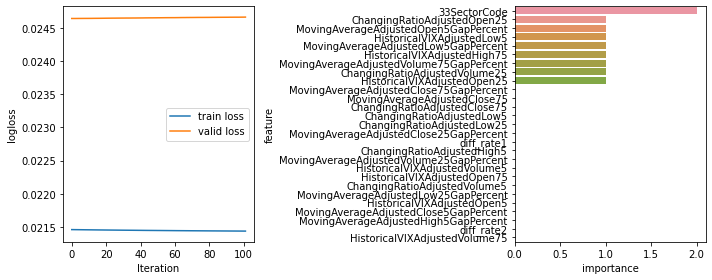

[I 2022-04-22 03:54:39,213] A new study created in memory with name: no-name-10fc409b-c1d2-4bba-9fa3-bb139ed5a66f
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0217841	Valid's rmse: 0.0222301
[200]	Train's rmse: 0.0217603	Valid's rmse: 0.0222

feature_fraction, val_score: 0.022203:  14%|#4        | 1/7 [00:15<01:33, 15.63s/it]

Early stopping, best iteration is:
[534]	Train's rmse: 0.0217066	Valid's rmse: 0.0222031
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

feature_fraction, val_score: 0.022203:  29%|##8       | 2/7 [00:32<01:20, 16.17s/it]

Early stopping, best iteration is:
[627]	Train's rmse: 0.0216896	Valid's rmse: 0.0222038
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

feature_fraction, val_score: 0.022203:  43%|####2     | 3/7 [00:47<01:02, 15.71s/it]

Early stopping, best iteration is:
[592]	Train's rmse: 0.021706	Valid's rmse: 0.0222067
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rm

feature_fraction, val_score: 0.022203:  57%|#####7    | 4/7 [01:00<00:44, 14.89s/it]

Early stopping, best iteration is:
[460]	Train's rmse: 0.0217147	Valid's rmse: 0.0222039
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

feature_fraction, val_score: 0.022203:  71%|#######1  | 5/7 [01:16<00:30, 15.14s/it]

Early stopping, best iteration is:
[615]	Train's rmse: 0.0216997	Valid's rmse: 0.0222048
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

feature_fraction, val_score: 0.022201:  86%|########5 | 6/7 [01:31<00:15, 15.11s/it]

Early stopping, best iteration is:
[525]	Train's rmse: 0.0217033	Valid's rmse: 0.0222013
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training unti

feature_fraction, val_score: 0.022201: 100%|##########| 7/7 [01:48<00:00, 15.56s/it]


Early stopping, best iteration is:
[640]	Train's rmse: 0.0217051	Valid's rmse: 0.0222064


num_leaves, val_score: 0.022201:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0216211	Valid's rmse: 0.0222307
[200]	Train's rmse: 0.0214638	Valid's rmse: 0.0222

num_leaves, val_score: 0.022201:   5%|5         | 1/20 [00:20<06:28, 20.44s/it]

Early stopping, best iteration is:
[150]	Train's rmse: 0.0215394	Valid's rmse: 0.0222283
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  10%|#         | 2/20 [00:39<05:51, 19.53s/it]

Early stopping, best iteration is:
[156]	Train's rmse: 0.0215878	Valid's rmse: 0.0222227
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  15%|#5        | 3/20 [00:59<05:40, 20.01s/it]

Early stopping, best iteration is:
[105]	Train's rmse: 0.0215759	Valid's rmse: 0.0222281
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  20%|##        | 4/20 [01:21<05:30, 20.63s/it]

Early stopping, best iteration is:
[206]	Train's rmse: 0.0215194	Valid's rmse: 0.0222208
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  25%|##5       | 5/20 [01:45<05:28, 21.91s/it]

Early stopping, best iteration is:
[151]	Train's rmse: 0.0215358	Valid's rmse: 0.0222296
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  30%|###       | 6/20 [02:02<04:42, 20.18s/it]

Early stopping, best iteration is:
[155]	Train's rmse: 0.0216247	Valid's rmse: 0.0222153
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  35%|###5      | 7/20 [02:24<04:29, 20.72s/it]

Early stopping, best iteration is:
[151]	Train's rmse: 0.0215309	Valid's rmse: 0.0222282
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  40%|####      | 8/20 [02:37<03:39, 18.32s/it]

Early stopping, best iteration is:
[210]	Train's rmse: 0.0216899	Valid's rmse: 0.0222067
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  45%|####5     | 9/20 [02:56<03:25, 18.68s/it]

Early stopping, best iteration is:
[210]	Train's rmse: 0.0215866	Valid's rmse: 0.0222134
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  50%|#####     | 10/20 [03:16<03:09, 18.90s/it]

Early stopping, best iteration is:
[105]	Train's rmse: 0.0215881	Valid's rmse: 0.0222289
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022200:  55%|#####5    | 11/20 [03:30<02:36, 17.44s/it]

Early stopping, best iteration is:
[614]	Train's rmse: 0.0217459	Valid's rmse: 0.0221997
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022200:  60%|######    | 12/20 [03:44<02:11, 16.50s/it]

Early stopping, best iteration is:
[531]	Train's rmse: 0.0217213	Valid's rmse: 0.0222026
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022200:  65%|######5   | 13/20 [03:56<01:45, 15.01s/it]

Early stopping, best iteration is:
[760]	Train's rmse: 0.0217903	Valid's rmse: 0.0222085
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022200:  70%|#######   | 14/20 [04:11<01:30, 15.04s/it]

Early stopping, best iteration is:
[210]	Train's rmse: 0.021657	Valid's rmse: 0.0222059
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rm

num_leaves, val_score: 0.022200:  75%|#######5  | 15/20 [04:25<01:12, 14.56s/it]

[700]	Train's rmse: 0.021755	Valid's rmse: 0.0222082
Early stopping, best iteration is:
[605]	Train's rmse: 0.0217603	Valid's rmse: 0.0222065
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validatio

num_leaves, val_score: 0.022200:  80%|########  | 16/20 [04:41<01:00, 15.07s/it]

Early stopping, best iteration is:
[205]	Train's rmse: 0.0216331	Valid's rmse: 0.0222089
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022200:  85%|########5 | 17/20 [05:00<00:49, 16.45s/it]

Early stopping, best iteration is:
[225]	Train's rmse: 0.0215858	Valid's rmse: 0.0222148
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022200:  90%|######### | 18/20 [05:13<00:30, 15.26s/it]

Early stopping, best iteration is:
[225]	Train's rmse: 0.0216924	Valid's rmse: 0.022209
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rm

num_leaves, val_score: 0.022200:  95%|#########5| 19/20 [05:31<00:16, 16.22s/it]

Early stopping, best iteration is:
[156]	Train's rmse: 0.0216063	Valid's rmse: 0.0222164
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022200: 100%|##########| 20/20 [05:47<00:00, 17.40s/it]


Early stopping, best iteration is:
[210]	Train's rmse: 0.0216379	Valid's rmse: 0.0222076


bagging, val_score: 0.022200:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0217978	Valid's rmse: 0.0222359
[200]	Train's rmse: 0.0217837	Valid's rmse: 0.0222

bagging, val_score: 0.022200:  10%|#         | 1/10 [00:13<01:59, 13.33s/it]

Early stopping, best iteration is:
[475]	Train's rmse: 0.0217569	Valid's rmse: 0.022216
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rm

bagging, val_score: 0.022200:  20%|##        | 2/10 [00:25<01:40, 12.57s/it]

Early stopping, best iteration is:
[465]	Train's rmse: 0.021757	Valid's rmse: 0.022211
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rms

bagging, val_score: 0.022200:  30%|###       | 3/10 [00:42<01:41, 14.46s/it]

Early stopping, best iteration is:
[614]	Train's rmse: 0.0217444	Valid's rmse: 0.0222059
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

bagging, val_score: 0.022200:  40%|####      | 4/10 [00:59<01:33, 15.62s/it]

Early stopping, best iteration is:
[672]	Train's rmse: 0.0217417	Valid's rmse: 0.0222036
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

bagging, val_score: 0.022200:  50%|#####     | 5/10 [01:15<01:18, 15.73s/it]

Early stopping, best iteration is:
[644]	Train's rmse: 0.0217441	Valid's rmse: 0.0222054
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

bagging, val_score: 0.022200:  60%|######    | 6/10 [01:31<01:03, 15.76s/it]

Early stopping, best iteration is:
[552]	Train's rmse: 0.0217518	Valid's rmse: 0.0222096
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

bagging, val_score: 0.022200:  70%|#######   | 7/10 [01:54<00:54, 18.10s/it]

Early stopping, best iteration is:
[884]	Train's rmse: 0.0217267	Valid's rmse: 0.0222044
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

bagging, val_score: 0.022200:  80%|########  | 8/10 [02:13<00:37, 18.54s/it]

Early stopping, best iteration is:
[672]	Train's rmse: 0.021743	Valid's rmse: 0.0222086
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rm

bagging, val_score: 0.022200:  90%|######### | 9/10 [02:30<00:17, 17.95s/it]

[700]	Train's rmse: 0.0217385	Valid's rmse: 0.0222105
Early stopping, best iteration is:
[607]	Train's rmse: 0.0217454	Valid's rmse: 0.02221
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation

bagging, val_score: 0.022200: 100%|##########| 10/10 [02:53<00:00, 17.32s/it]


Early stopping, best iteration is:
[716]	Train's rmse: 0.0217403	Valid's rmse: 0.0222104


feature_fraction_stage2, val_score: 0.022200:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0217979	Valid's rmse: 0.0222334
[200]	Train's rmse: 0.0217833	Valid's rmse: 0.0222

feature_fraction_stage2, val_score: 0.022200:  33%|###3      | 1/3 [00:13<00:27, 13.80s/it]

Early stopping, best iteration is:
[614]	Train's rmse: 0.0217459	Valid's rmse: 0.0221997
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

feature_fraction_stage2, val_score: 0.022200:  67%|######6   | 2/3 [00:28<00:14, 14.17s/it]

Early stopping, best iteration is:
[613]	Train's rmse: 0.0217458	Valid's rmse: 0.0222005
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

feature_fraction_stage2, val_score: 0.022199: 100%|##########| 3/3 [00:42<00:00, 14.01s/it]


[700]	Train's rmse: 0.0217405	Valid's rmse: 0.022201
Early stopping, best iteration is:
[606]	Train's rmse: 0.021747	Valid's rmse: 0.0221993


regularization_factors, val_score: 0.022199:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0217974	Valid's rmse: 0.0222358
[200]	Train's rmse: 0.0217819	Valid's rmse: 0.0222

regularization_factors, val_score: 0.022199:   5%|5         | 1/20 [00:11<03:46, 11.95s/it]

Early stopping, best iteration is:
[585]	Train's rmse: 0.0217417	Valid's rmse: 0.0222112
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022199:  10%|#         | 2/20 [00:24<03:44, 12.48s/it]

Early stopping, best iteration is:
[585]	Train's rmse: 0.0217417	Valid's rmse: 0.0222111
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022199:  15%|#5        | 3/20 [00:36<03:29, 12.32s/it]

Early stopping, best iteration is:
[585]	Train's rmse: 0.021743	Valid's rmse: 0.022209
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rms

regularization_factors, val_score: 0.022199:  20%|##        | 4/20 [00:50<03:27, 12.96s/it]

Early stopping, best iteration is:
[530]	Train's rmse: 0.0217584	Valid's rmse: 0.0222054
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022199:  25%|##5       | 5/20 [01:02<03:08, 12.59s/it]

Early stopping, best iteration is:
[585]	Train's rmse: 0.0217417	Valid's rmse: 0.0222113
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022199:  30%|###       | 6/20 [01:14<02:53, 12.36s/it]

Early stopping, best iteration is:
[585]	Train's rmse: 0.0217417	Valid's rmse: 0.022212
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rm

regularization_factors, val_score: 0.022199:  35%|###5      | 7/20 [01:27<02:43, 12.56s/it]

Early stopping, best iteration is:
[585]	Train's rmse: 0.0217417	Valid's rmse: 0.0222112
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022199:  40%|####      | 8/20 [01:39<02:28, 12.38s/it]

Early stopping, best iteration is:
[585]	Train's rmse: 0.0217417	Valid's rmse: 0.0222112
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022199:  45%|####5     | 9/20 [01:52<02:16, 12.37s/it]

Early stopping, best iteration is:
[585]	Train's rmse: 0.0217417	Valid's rmse: 0.0222112
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022199:  50%|#####     | 10/20 [02:04<02:03, 12.38s/it]

Early stopping, best iteration is:
[585]	Train's rmse: 0.0217417	Valid's rmse: 0.0222112
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022199:  55%|#####5    | 11/20 [02:18<01:55, 12.80s/it]

Early stopping, best iteration is:
[531]	Train's rmse: 0.0217706	Valid's rmse: 0.0222156
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022199:  60%|######    | 12/20 [02:36<01:54, 14.33s/it]

Early stopping, best iteration is:
[590]	Train's rmse: 0.0217471	Valid's rmse: 0.0222007
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022199:  65%|######5   | 13/20 [02:49<01:38, 14.07s/it]

Early stopping, best iteration is:
[532]	Train's rmse: 0.0217654	Valid's rmse: 0.0222151
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022199:  70%|#######   | 14/20 [03:03<01:23, 13.91s/it]

Early stopping, best iteration is:
[585]	Train's rmse: 0.0217435	Valid's rmse: 0.022208
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rm

regularization_factors, val_score: 0.022199:  75%|#######5  | 15/20 [03:14<01:06, 13.27s/it]

Early stopping, best iteration is:
[526]	Train's rmse: 0.0217504	Valid's rmse: 0.0222025
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022199:  80%|########  | 16/20 [03:26<00:51, 12.90s/it]

Early stopping, best iteration is:
[585]	Train's rmse: 0.0217423	Valid's rmse: 0.0222086
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022199:  85%|########5 | 17/20 [03:39<00:38, 12.85s/it]

Early stopping, best iteration is:
[585]	Train's rmse: 0.0217418	Valid's rmse: 0.0222105
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022199:  90%|######### | 18/20 [03:51<00:25, 12.52s/it]

Early stopping, best iteration is:
[526]	Train's rmse: 0.0217506	Valid's rmse: 0.0222038
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022199:  95%|#########5| 19/20 [04:05<00:12, 12.96s/it]

Early stopping, best iteration is:
[590]	Train's rmse: 0.0217466	Valid's rmse: 0.0222011
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022199: 100%|##########| 20/20 [04:16<00:00, 12.84s/it]


Early stopping, best iteration is:
[548]	Train's rmse: 0.021745	Valid's rmse: 0.0222121


min_data_in_leaf, val_score: 0.022199:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0217979	Valid's rmse: 0.0222332
[200]	Train's rmse: 0.0217836	Valid's rmse: 0.0222

min_data_in_leaf, val_score: 0.022199:  20%|##        | 1/5 [00:13<00:54, 13.57s/it]

[700]	Train's rmse: 0.0217405	Valid's rmse: 0.022201
Early stopping, best iteration is:
[606]	Train's rmse: 0.021747	Valid's rmse: 0.0221993
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation sco

min_data_in_leaf, val_score: 0.022199:  40%|####      | 2/5 [00:27<00:41, 13.97s/it]

[700]	Train's rmse: 0.0217405	Valid's rmse: 0.022201
Early stopping, best iteration is:
[606]	Train's rmse: 0.021747	Valid's rmse: 0.0221993
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation

min_data_in_leaf, val_score: 0.022199:  60%|######    | 3/5 [00:41<00:27, 13.70s/it]

[700]	Train's rmse: 0.0217405	Valid's rmse: 0.022201
Early stopping, best iteration is:
[606]	Train's rmse: 0.021747	Valid's rmse: 0.0221993
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until valida

min_data_in_leaf, val_score: 0.022199:  80%|########  | 4/5 [00:55<00:13, 13.97s/it]

[700]	Train's rmse: 0.0217405	Valid's rmse: 0.022201
Early stopping, best iteration is:
[606]	Train's rmse: 0.021747	Valid's rmse: 0.0221993
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation

min_data_in_leaf, val_score: 0.022199: 100%|##########| 5/5 [01:09<00:00, 13.83s/it]

[700]	Train's rmse: 0.0217405	Valid's rmse: 0.022201
Early stopping, best iteration is:
[606]	Train's rmse: 0.021747	Valid's rmse: 0.0221993


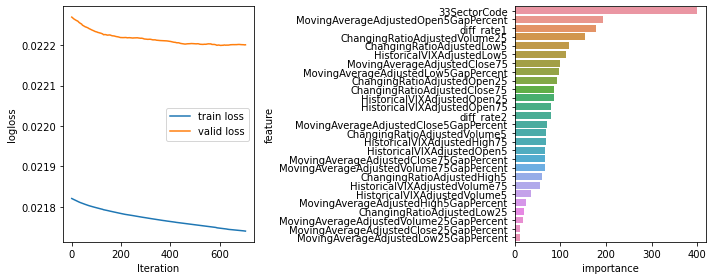

[I 2022-04-22 04:11:18,666] A new study created in memory with name: no-name-90de0784-5389-4432-b723-45463b56801b
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0215202	Valid's rmse: 0.0251051
[200]	Train's rmse: 0.0214947	Valid's rmse: 0.0250

feature_fraction, val_score: 0.025038:  14%|#4        | 1/7 [00:22<02:16, 22.72s/it]

Early stopping, best iteration is:
[1030]	Train's rmse: 0.021387	Valid's rmse: 0.0250378
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's r

feature_fraction, val_score: 0.025030:  29%|##8       | 2/7 [00:46<01:56, 23.24s/it]

Early stopping, best iteration is:
[1027]	Train's rmse: 0.0213792	Valid's rmse: 0.0250297
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's 

feature_fraction, val_score: 0.025030:  43%|####2     | 3/7 [01:08<01:31, 22.86s/it]

Early stopping, best iteration is:
[1029]	Train's rmse: 0.0213837	Valid's rmse: 0.0250321
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's 

feature_fraction, val_score: 0.025019:  57%|#####7    | 4/7 [01:33<01:11, 23.73s/it]

Early stopping, best iteration is:
[1052]	Train's rmse: 0.0213719	Valid's rmse: 0.0250194
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's 

feature_fraction, val_score: 0.025018:  71%|#######1  | 5/7 [02:07<00:54, 27.43s/it]

[2000]	Train's rmse: 0.0213158	Valid's rmse: 0.0250176
Did not meet early stopping. Best iteration is:
[2000]	Train's rmse: 0.0213158	Valid's rmse: 0.0250176
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training

feature_fraction, val_score: 0.025018:  86%|########5 | 6/7 [02:34<00:27, 27.16s/it]

Early stopping, best iteration is:
[1147]	Train's rmse: 0.0213639	Valid's rmse: 0.0250215
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's 

feature_fraction, val_score: 0.025018: 100%|##########| 7/7 [02:59<00:00, 25.67s/it]


Early stopping, best iteration is:
[1030]	Train's rmse: 0.0213739	Valid's rmse: 0.0250205


num_leaves, val_score: 0.025018:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.021393	Valid's rmse: 0.0250771
[200]	Train's rmse: 0.0212592	Valid's rmse: 0.02504

num_leaves, val_score: 0.024999:   5%|5         | 1/20 [00:47<14:53, 47.04s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214992	Valid's rmse: 0.0250991
[200]	Train's rmse: 0.0214568	Valid's rmse: 0.0250

num_leaves, val_score: 0.024998:  10%|#         | 2/20 [01:18<11:26, 38.16s/it]

Early stopping, best iteration is:
[1195]	Train's rmse: 0.0212323	Valid's rmse: 0.0249981
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's 

num_leaves, val_score: 0.024979:  15%|#5        | 3/20 [02:10<12:33, 44.30s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214486	Valid's rmse: 0.025084
[200]	Train's rmse: 0.0213646	Valid's rmse: 0.02505

num_leaves, val_score: 0.024978:  20%|##        | 4/20 [02:58<12:08, 45.54s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214202	Valid's rmse: 0.0250797
[200]	Train's rmse: 0.0213117	Valid's rmse: 0.0250

num_leaves, val_score: 0.024978:  25%|##5       | 5/20 [03:54<12:23, 49.54s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214081	Valid's rmse: 0.0250783
[200]	Train's rmse: 0.0212888	Valid's rmse: 0.0250

num_leaves, val_score: 0.024978:  30%|###       | 6/20 [04:57<12:35, 53.95s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214915	Valid's rm

num_leaves, val_score: 0.024978:  35%|###5      | 7/20 [05:35<10:35, 48.86s/it]

Early stopping, best iteration is:
[1144]	Train's rmse: 0.0211867	Valid's rmse: 0.0249984
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's 

num_leaves, val_score: 0.024978:  40%|####      | 8/20 [06:37<10:37, 53.16s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.021387	Valid's rmse: 0.0250757
[200]	Train's rmse: 0.0212482	Valid's rmse: 0.02504

num_leaves, val_score: 0.024978:  45%|####5     | 9/20 [07:47<10:40, 58.22s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214269	Valid's rmse: 0.025082
[200]	Train's rmse: 0.021324	Valid's rmse: 0.025051

num_leaves, val_score: 0.024978:  50%|#####     | 10/20 [08:25<08:41, 52.15s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214665	Valid's rmse: 0.0250892
[200]	Train's rmse: 0.0213978	Valid's rmse: 0.0250

num_leaves, val_score: 0.024978:  55%|#####5    | 11/20 [09:11<07:31, 50.14s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214422	Valid's rmse: 0.0250835
[200]	Train's rmse: 0.0213522	Valid's rmse: 0.0250

num_leaves, val_score: 0.024978:  60%|######    | 12/20 [10:01<06:39, 50.00s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214517	Valid's rmse: 0.025084
[200]	Train's rmse: 0.02137	Valid's rmse: 0.0250528

num_leaves, val_score: 0.024978:  65%|######5   | 13/20 [10:34<05:15, 45.07s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214521	Valid's rmse: 0.025083
[200]	Train's rmse: 0.0213711	Valid's rmse: 0.02505

num_leaves, val_score: 0.024978:  70%|#######   | 14/20 [11:27<04:43, 47.22s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.021461	Valid's rmse: 0.0250865
[200]	Train's rmse: 0.0213874	Valid's rmse: 0.02505

num_leaves, val_score: 0.024978:  75%|#######5  | 15/20 [12:14<03:56, 47.25s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214069	Valid's rmse: 0.0250782
[200]	Train's rmse: 0.021286	Valid's rmse: 0.02504

num_leaves, val_score: 0.024978:  80%|########  | 16/20 [13:15<03:26, 51.56s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.021373	Valid's rmse: 0.0250769
[200]	Train's rmse: 0.0212215	Valid's rmse: 0.02504

num_leaves, val_score: 0.024978:  85%|########5 | 17/20 [14:30<02:55, 58.37s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0215512	Valid's rmse: 0.0251341
[200]	Train's rmse: 0.0215423	Valid's rmse: 0.0251

num_leaves, val_score: 0.024978:  90%|######### | 18/20 [14:36<01:25, 42.72s/it]

Early stopping, best iteration is:
[451]	Train's rmse: 0.0215298	Valid's rmse: 0.0251183
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.024976:  95%|#########5| 19/20 [15:28<00:45, 45.43s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214348	Valid's rmse: 0.0250819
[200]	Train's rmse: 0.0213388	Valid's rmse: 0.0250

bagging, val_score: 0.024976:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214346	Valid's rmse: 0.0250809
[200]	Train's rmse: 0.0213397	Valid's rmse: 0.0250

bagging, val_score: 0.024976:  10%|#         | 1/10 [00:43<06:32, 43.60s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.021442	Valid's rmse: 0.0250867
[200]	Train's rmse: 0.0213506	Valid's rmse: 0.02505

bagging, val_score: 0.024976:  20%|##        | 2/10 [01:30<06:02, 45.35s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214332	Valid's rmse: 0.025081
[200]	Train's rmse: 0.0213366	Valid's rmse: 0.02505

bagging, val_score: 0.024976:  30%|###       | 3/10 [02:23<05:42, 48.96s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214348	Valid's rmse: 0.0250836
[200]	Train's rmse: 0.0213385	Valid's rmse: 0.0250

bagging, val_score: 0.024976:  40%|####      | 4/10 [03:20<05:13, 52.31s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214384	Valid's rmse: 0.0250859
[200]	Train's rmse: 0.0213454	Valid's rmse: 0.0250

bagging, val_score: 0.024976:  50%|#####     | 5/10 [04:12<04:19, 51.89s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214437	Valid's rmse: 0.0250815
[200]	Train's rmse: 0.021355	Valid's rmse: 0.02505

bagging, val_score: 0.024976:  60%|######    | 6/10 [04:56<03:17, 49.31s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214335	Valid's rmse: 0.0250809
[200]	Train's rmse: 0.0213362	Valid's rmse: 0.0250

bagging, val_score: 0.024976:  70%|#######   | 7/10 [05:45<02:27, 49.23s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214346	Valid's rmse: 0.0250816
[200]	Train's rmse: 0.0213399	Valid's rmse: 0.0250

bagging, val_score: 0.024976:  80%|########  | 8/10 [06:45<01:45, 52.79s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214413	Valid's rmse: 0.0250821
[200]	Train's rmse: 0.02135	Valid's rmse: 0.025050

bagging, val_score: 0.024976:  90%|######### | 9/10 [07:35<00:51, 51.76s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214373	Valid's rmse: 0.025084
[200]	Train's rmse: 0.0213443	Valid's rmse: 0.02505

feature_fraction_stage2, val_score: 0.024976:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214327	Valid's rmse: 0.0250761
[200]	Train's rmse: 0.0213371	Valid's rmse: 0.0250

In [ ]:
# 2020-12-23よりも前のデータは証券コードが2000個すべて揃っていないため、これ以降のデータのみを使う。
# (学習用データの開始日、学習用データの終了日＝検証用データの開始日、検証用データの終了日)
fold_params = [
    ('2020-12-23', '2021-11-01', '2021-12-01'),
    ('2021-01-23', '2021-12-01', '2022-01-01'),
    ('2021-02-23', '2022-01-01', '2022-02-01'),
]
models = trainer(feature_df, feat_cols, label_col, fold_params, use_cache=False)
models

# Evaluation

In [ ]:
def predictor(feature_df, feat_cols, models, is_train=True):
    X = feature_df[feat_cols]
    
    # 推論
    preds = list(map(lambda model: model.predict(X, num_iteration=model.best_iteration), models))
    print(preds)
    
    # スコアは学習時のみ計算
    if is_train:
        scores = list(map(lambda pred: evaluator(feature_df, pred), preds))
        print("SCORES:", scores)

    # 推論結果をバギング
    pred = np.array(preds).mean(axis=0)

    # スコアは学習時のみ計算
    if is_train:
        score = evaluator(feature_df, pred)
        print("SCORE:", score)
    
    return pred

def eval_predictor(df, feat_cols, models, target_date=['2022-01-05', '2022-01-06']):
    # 日次で推論・登録
    results = []
    for current_date in target_date:
        past_df = df.copy()
        print(f"round: {current_date}")

        # 未来のデータを削除
        target_df = past_df[past_df["Date"] == current_date]

        # 推論20
        target_df["pred"] = predictor(target_df, feat_cols, models, True)

        # 推論結果からRANKを導出し、提出データに反映
        target_df = add_rank(target_df)
        #feature_map = feature_df.set_index('SecuritiesCode')['Rank'].to_dict()
        results.append(target_df)
    return results

In [ ]:
_df = predictor_date(feature_df, feat_cols, models)
pred_df = _df[0]
pred_df = pred_df[["SecuritiesCode", "pred", "Date", "Rank"]]
target_df = _df[1]
target_df = target_df[["SecuritiesCode", "Target"]]
result_df = pred_df.merge(target_df, on='SecuritiesCode', how="left")
result_df
write_df(result_df, "result_df")

# Submit

In [ ]:
# 時系列APIのロード
import jpx_tokyo_market_prediction
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

In [ ]:
# supplemental filesを履歴データの初期状態としてセットアップ
past_df = train_df.copy()

In [ ]:
# 日次で推論・登録
for i, (prices, options, financials, trades, secondary_prices, sample_prediction) in enumerate(iter_test):
    current_date = prices["Date"].iloc[0]
    print(f"count {i}, {current_date}")

    if i == 0:
        # リークを防止するため、時系列APIから受け取ったデータより未来のデータを削除
        past_df = past_df[past_df["Date"] < current_date]

    # リソース確保のため古い履歴を削除
    threshold = (pd.Timestamp(current_date) - pd.offsets.BDay(80)).strftime("%Y-%m-%d")
    past_df = past_df[past_df["Date"] >= threshold]
    
    # 時系列APIから受け取ったデータを履歴データに統合
    base_df = collector(prices, options, financials, trades, secondary_prices, stock_list)
    past_df = pd.concat([past_df, base_df]).reset_index(drop=True)

    # 特徴量エンジニアリング
    feature_df, feat_cols, label_col = preprocessor(past_df, False)

    # 予測対象レコードだけを抽出
    feature_df = feature_df[feature_df['Date'] == current_date]

    # 推論
    feature_df["pred"] = predictor(feature_df, feat_cols, models, False)

    # 推論結果からRANKを導出し、提出データに反映
    feature_df = add_rank(feature_df)
    write_df(feature_df, f"result_{i}")
    feature_map = feature_df.set_index('SecuritiesCode')['Rank'].to_dict()
    sample_prediction['Rank'] = sample_prediction['SecuritiesCode'].map(feature_map)

    # 結果を登録
    env.predict(sample_prediction)